In [3]:
import sys
sys.path.insert(1,"../src")
import pandas as pd
import matplotlib.pyplot as plt
# import nupack as n
import numpy as np
import gardn_util
import util
import tensorflow as tf
tfkl = tf.keras.layers
import keras as tfk
from tfa_spectral import SpectralNormalization as SN
from attention_util import SelfAttnModel
import gardn_util
print('loaded')

loaded


Metal device set to: Apple M1 Ultra


2024-08-14 19:06:33.700727: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-14 19:06:33.700994: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


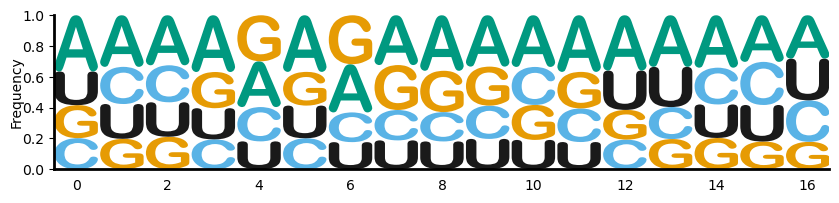

In [6]:
seq_test = np.load('../data/RBS_data/sequences_test.npy')
seq_test = pd.DataFrame(data=seq_test,columns=['Sequences']) # create a DataFrame with the loaded sequence data and names the column 'Sequences'
seq_test = util.one_hot_encode(seq_test) # apply one hot encoding
util.plot_logo(seq_test)
# plt.savefig('figures/seq_logo_real_dataset.svg',transparent=True)



idx = np.arange(0,seq_test.shape[0])
np.random.shuffle(idx)

seqs = seq_test[idx,:,:]
seqs = seqs.astype('float32')
seqs = tf.expand_dims(seqs,axis=-1)
seq_inputs = tf.data.Dataset.from_tensor_slices(seqs) # convert one-hot arrays to a tensor dataset


In [7]:
# creates an instance of the GARDN RBS discriminator
disc = gardn_util.create_GARDN_RBS_discriminator()


gen = gardn_util.create_GARDN_RBS_generator()


Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4, 17, 1)]        0         
                                                                 
 spectral_normalization (Spe  (None, 1, 17, 128)       25856     
 ctralNormalization)                                             
                                                                 
 layer_normalization (LayerN  (None, 1, 17, 128)       256       
 ormalization)                                                   
                                                                 
 spectral_normalization_1 (S  (None, 1, 17, 64)        147584    
 pectralNormalization)                                           
                                                                 
 layer_normalization_1 (Laye  (None, 1, 17, 64)        128       
 rNormalization)                                     

In [9]:
init = True
EPOCHS = 20 


if init == True:
    g_loss_save = []
    d_loss_save = []
    gp_loss_save = []

    discriminator = gardn_util.create_GARDN_RBS_discriminator(filters=128)
    generator = gardn_util.create_GARDN_RBS_generator(latent_dim=8, filters = 128)

In [11]:
g_loss_save,d_loss_save,gp_loss_save = gardn_util.train(generator,
                                                        discriminator,
                                                        seq_inputs,
                                                        EPOCHS,
                                                        3,
                                                        64,
                                                        z_dim=8, # size of the input to the generator - keep it as small as posssible
                                                        g_loss_save=g_loss_save,
                                                        d_loss_save=d_loss_save,
                                                        gp_loss_save=gp_loss_save)

epoch: 0


2024-08-14 19:06:45.304064: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-08-14 19:06:45.307346: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


KeyboardInterrupt: 

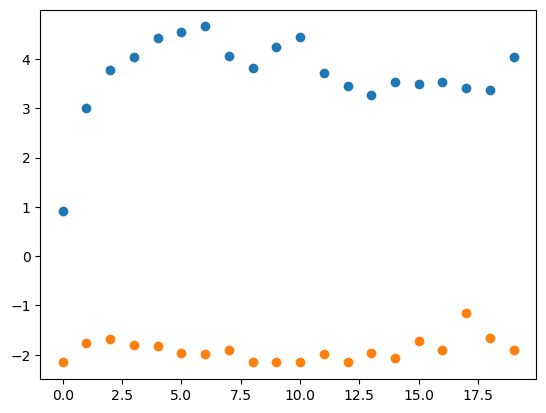

In [8]:
# plotting the lossess to see if it has stabilized
plt.figure()
plt.scatter(np.arange(0,len(g_loss_save)),g_loss_save)
plt.scatter(np.arange(0,len(g_loss_save)),d_loss_save)

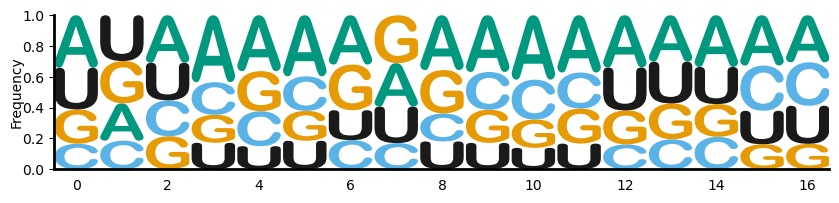

In [33]:
a = np.random.normal(size=(15000,8))
generated_seqs = generator(a)
util.plot_logo(generated_seqs)
plt.savefig('figures/seq_logo_gardn.svg',transparent=True)

In [36]:
generator.save('models/gardn_rbs_02_22_24_original_final')

INFO:tensorflow:Assets written to: models/gardn_rbs_02_22_24_original_final/assets


INFO:tensorflow:Assets written to: models/gardn_rbs_02_22_24_original_final/assets
